In [1]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import lightgbm
import shap
import itertools
import pickle
pd.options.mode.chained_assignment = None

os.chdir('/Users/stevengeorge/Documents/Github/fpl-analysis/')

from src.data.gw_features import add_gw_features
from src.features.custom_transformers import TimeSeriesFeatures
from src.models.constants import TIME_SERIES_FEATURES, STATIC_FEATURES

%matplotlib inline
pd.set_option('display.max_columns', None)
DATA_PATH = 'data/processed/'

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


__Get data for 2016/17 season to 2018/19 season__

In [40]:
fpl_data_all_seasons = pd.read_parquet(DATA_PATH + 'fpl_data_2016_to_2019.parquet')
print(fpl_data_all_seasons.shape)
fpl_data_all_seasons.head()

(67986, 73)


,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,ID
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,2016-17,West Ham United,0,0,1,0,0,0,Chelsea,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,2016-17,West Ham United,0,0,1,0,0,0,Bournemouth,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,2016-17,West Ham United,0,0,1,0,0,0,Manchester City,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,2016-17,West Ham United,0,0,1,0,0,0,Watford,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,2016-17,West Ham United,0,0,1,0,0,0,West Bromwich Albion,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [41]:
fpl_data_all_seasons['season_order'] = fpl_data_all_seasons['season'].map({
    '2016-17': 1,
    '2017-18': 2,
    '2018-19': 3,
    '2019-20': 4
})

In [42]:
fpl_data_all_seasons.sort_values(['name', 'season_order', 'gw'], inplace=True)
fpl_data_all_seasons.reset_index(drop=True, inplace=True)

Create new ID

In [43]:
fpl_data_all_seasons.drop('ID', axis=1, inplace=True)

In [44]:
id_df = fpl_data_all_seasons.groupby(['name']).count().reset_index()[['name']]
id_df['ID'] = id_df.index + 1
print(id_df.shape)
id_df.head()

(1090, 2)


,name,ID
0,aaron_cresswell,1
1,aaron_lennon,2
2,aaron_mooy,3
3,aaron_ramsdale,4
4,aaron_ramsey,5


In [45]:
fpl_data_all_seasons = fpl_data_all_seasons.merge(id_df, how='left', on=['name'])

### Shift forward static features e.g. next opponnent etc.

In [46]:
AVAILABLE_COLUMNS

['name',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'minutes',
 'own_goals',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'total_points',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'value',
 'was_home',
 'yellow_cards',
 'gw',
 'season',
 'team_name',
 'promoted_side',
 'top_6_last_season',
 'position_DEF',
 'position_FWD',
 'position_GK',
 'position_MID',
 'team_name_opponent',
 'promoted_side_opponent',
 'top_6_last_season_opponent',
 'kickoff_month_Aug',
 'late_kickoff',
 'early_kickoff',
 'ID',
 'kickoff_month_Apr',
 'kickoff_month_Dec',
 'kickoff_month_Feb',
 'kickoff_month_Jan',
 'kickoff_month_Mar',
 'kickoff_month_May',
 'kickoff_month_Nov',
 'kickoff_month_Oct',
 'kickoff_month_Sep']

In [47]:
fpl_data_all_seasons = fpl_data_all_seasons[AVAILABLE_COLUMNS]

In [48]:
fpl_data_all_seasons.head(1)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,ID,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep
0,aaron_cresswell,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,1,2016-17,West Ham United,0,0,1,0,0,0,Chelsea,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0


In [49]:
for feature in ['value', 'was_home', 'promoted_side_opponent', 'top_6_last_season_opponent', 'kickoff_month_Apr', 'kickoff_month_Aug', 'kickoff_month_Dec',
                'kickoff_month_Feb', 'kickoff_month_Jan', 'kickoff_month_Mar', 'kickoff_month_May', 'kickoff_month_Nov', 'kickoff_month_Oct', 
                'kickoff_month_Sep', 'late_kickoff', 'early_kickoff']:
    fpl_data_all_seasons[f'next_match_{feature}'] = fpl_data_all_seasons.groupby('name')[f'{feature}'].shift(-1)

In [50]:
fpl_data_all_seasons.head(2)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,ID,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff
0,aaron_cresswell,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,1,2016-17,West Ham United,0,0,1,0,0,0,Chelsea,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,5.5,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aaron_cresswell,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,11531,0,1,0.0,0,-3002,79,3081,5.5,True,0,2,2016-17,West Ham United,0,0,1,0,0,0,Bournemouth,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,5.4,False,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create time series features

In [51]:
AVAILABLE_COLUMNS

['name',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'minutes',
 'own_goals',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'total_points',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'value',
 'was_home',
 'yellow_cards',
 'gw',
 'season',
 'team_name',
 'promoted_side',
 'top_6_last_season',
 'position_DEF',
 'position_FWD',
 'position_GK',
 'position_MID',
 'team_name_opponent',
 'promoted_side_opponent',
 'top_6_last_season_opponent',
 'kickoff_month_Aug',
 'late_kickoff',
 'early_kickoff',
 'ID',
 'kickoff_month_Apr',
 'kickoff_month_Dec',
 'kickoff_month_Feb',
 'kickoff_month_Jan',
 'kickoff_month_Mar',
 'kickoff_month_May',
 'kickoff_month_Nov',
 'kickoff_month_Oct',
 'kickoff_month_Sep']

In [52]:
TIME_SERIES_FEATURES

['assists',
 'bonus',
 'target_missed',
 'errors_leading_to_goal_attempt',
 'creativity',
 'key_passes',
 'yellow_cards',
 'loaned_in',
 'team_a_score',
 'team_h_score',
 'clearances_blocks_interceptions',
 'offside',
 'dribbles',
 'loaned_out',
 'selected',
 'big_chances_missed',
 'ict_index',
 'red_cards',
 'value',
 'fouls',
 'influence',
 'errors_leading_to_goal',
 'ea_index',
 'goals_scored',
 'tackles',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'attempted_passes',
 'completed_passes',
 'bps',
 'penalties_missed',
 'own_goals',
 'saves',
 'penalties_saved',
 'goals_conceded',
 'open_play_crosses',
 'total_points',
 'tackled',
 'clean_sheets',
 'winning_goals',
 'minutes',
 'big_chances_created',
 'penalties_conceded',
 'recoveries',
 'threat']

In [53]:
TIME_SERIES_FEATURES_LITE = list(set(AVAILABLE_COLUMNS).intersection(TIME_SERIES_FEATURES))

In [54]:
ts_features = TimeSeriesFeatures(halflife=4, max_lag=4, max_diff=4, columns=TIME_SERIES_FEATURES_LITE)

In [55]:
%%time
fpl_data_all_seasons_with_ts = ts_features.fit_transform(fpl_data_all_seasons)
print(fpl_data_all_seasons_with_ts.shape)

(67986, 293)
CPU times: user 1min 49s, sys: 30.1 s, total: 2min 19s
Wall time: 1min 35s


In [56]:
fpl_data_all_seasons_with_ts.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,ID,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,saves_EMA,saves_L1,saves_L2,saves_L3,saves_L4,saves_D1,saves_D2,saves_D3,saves_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,bps_EMA,bps_L1,bps_L2,bps_L3,bps_L4,bps_D1,bps_D2,bps_D3,bps_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_

__TODO: Replace with Imputer__

In [57]:
mean_total_points = fpl_data_all_seasons_with_ts['total_points'].mean()
mean_total_points

1.3767687465066336

In [58]:
# Target cannot contain any nulls
fpl_data_all_seasons_with_ts['total_points_plus_1_gw'] = fpl_data_all_seasons_with_ts.groupby(['name'])['total_points'].shift(-1).fillna(mean_total_points)

In [59]:
fpl_data_all_seasons_with_ts['season_order'] = fpl_data_all_seasons_with_ts['season'].map({
    '2016-17': 1,
    '2017-18': 2,
    '2018-19': 3,
    '2019-20': 4
})

In [60]:
fpl_data_all_seasons_with_ts.sort_values(['name', 'season_order', 'gw'], inplace=True)
fpl_data_all_seasons_with_ts.reset_index(drop=True, inplace=True)

Create new ID

In [61]:
fpl_data_all_seasons_with_ts.drop('ID', axis=1, inplace=True)

In [62]:
id_df = fpl_data_all_seasons_with_ts.groupby(['name']).count().reset_index()[['name']]
id_df['ID'] = id_df.index + 1
print(id_df.shape)
id_df.head()

(1090, 2)


,name,ID
0,aaron_cresswell,1
1,aaron_lennon,2
2,aaron_mooy,3
3,aaron_ramsdale,4
4,aaron_ramsey,5


In [63]:
fpl_data_all_seasons_with_ts = fpl_data_all_seasons_with_ts.merge(id_df, how='left', on=['name'])

### Create train set (drop last GW of latest season)

In [64]:
train = fpl_data_all_seasons_with_ts[
    ~((fpl_data_all_seasons_with_ts['season_order'] == 3) & (fpl_data_all_seasons_with_ts['gw'] == 38))
]
train.shape

(67360, 295)

In [65]:
train.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,saves_EMA,saves_L1,saves_L2,saves_L3,saves_L4,saves_D1,saves_D2,saves_D3,saves_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,bps_EMA,bps_L1,bps_L2,bps_L3,bps_L4,bps_D1,bps_D2,bps_D3,bps_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,

### Fit model on everything except GW 38 of 2019-20

In [66]:
train_copy = train.copy()

In [67]:
train_copy.drop(
    ['total_points', 'name', 'season', 'team_name', 'team_name_opponent'],
    axis=1,
    inplace=True
)

In [68]:
print(train_copy.shape)
train_copy = train_copy[~train_copy['next_match_was_home'].isnull()]
train_copy['next_match_was_home'] = train_copy['next_match_was_home'].astype(bool)
train_copy.shape

(67360, 290)


(66893, 290)

In [69]:
gs_params = {
    'learning_rate': 0.03,
     'max_depth': -1,
     'n_estimators': 200,
     'num_leaves': 50,
     'reg_alpha': 0.03
}
lgbm_model = lightgbm.LGBMRegressor(**gs_params)

In [70]:
lgbm_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.03, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.03, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [71]:
%%time
lgbm_model.fit(
    train_copy.drop(['total_points_plus_1_gw', 'ID'], axis=1),
    train_copy['total_points_plus_1_gw']
)

CPU times: user 1min 13s, sys: 2.65 s, total: 1min 16s
Wall time: 23.5 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.03, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.03, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [72]:
predictions = lgbm_model.predict(
    train_copy.drop(['total_points_plus_1_gw', 'ID'], axis=1)
)

In [73]:
mean_squared_error(
    train_copy['total_points_plus_1_gw'],
    predictions
)

3.4956881681083156

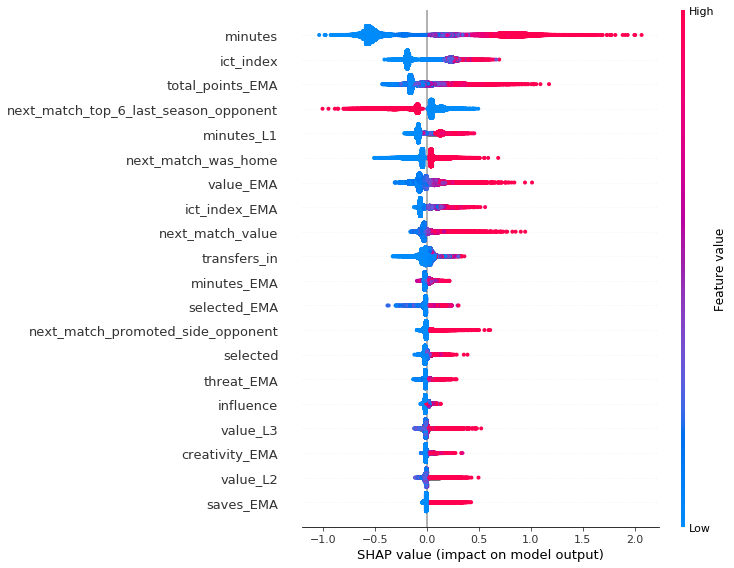

In [74]:
# LightGBM shap
shap_values = shap.TreeExplainer(lgbm_model).shap_values(
    train_copy.drop(['total_points_plus_1_gw', 'ID'], axis=1)
)
shap.summary_plot(
    shap_values,
    train_copy.drop(['total_points_plus_1_gw', 'ID'], axis=1)
)

In [75]:
# save the model to disk
model_fp = 'src/models/pickles/'
pickle.dump(lgbm_model, open(model_fp + 'v1.1_lgbm_model', 'wb'))

In [76]:
# load the model from disk
# loaded_model = pickle.load(open(model_fp + 'v1.1_lgbm_model', 'rb'))

### Make GW 2 2019/20 predictions

In [77]:
from src.data.historic_data import _combine_player_and_gameweek_data

In [78]:
#fpl_data_all_seasons = pd.read_parquet(DATA_PATH + 'fpl_data_2016_to_2019.parquet')
#print(fpl_data_all_seasons.shape)
#fpl_data_all_seasons.head()

In [79]:
gw1_2019_points = _combine_player_and_gameweek_data(season='2019-20', starting_gameweek=1, last_gameweek=1)
print(gw1_2019_points.shape)
gw1_2019_points.head()

2019-08-17 01:42:17,656 - Number of players not matched: 0
2019-08-17 01:42:17,662 - Proportion of no name matches: 0.0


(526, 41)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,first_name,second_name,team,position,team_name,promoted_side,top_6_last_season
0,aaron_cresswell,0,0,7,0,1.5,376,8,5,0,1.1,9.0,2019-08-10 12:30:00+01:00,90,11,0,0,0,0,1,0,23399,5,0,0.0,0,0,0,0,5.0,True,0,1,2019-20,Aaron,Cresswell,19,DEF,West Ham United,0,0
1,aaron_lennon,0,0,3,0,0.0,430,3,0,0,0.2,2.0,2019-08-10 15:00:00+01:00,6,16,0,0,0,0,1,0,8105,0,3,0.0,1,0,0,0,5.0,True,0,1,2019-20,Aaron,Lennon,5,MID,Burnley,0,0
2,aaron_mooy,0,0,0,0,0.0,516,7,0,0,0.0,0.0,2019-08-10 15:00:00+01:00,0,18,0,0,0,0,1,0,16261,3,0,0.0,0,0,0,0,5.0,False,0,1,2019-20,Aaron,Mooy,4,MID,Brighton & Hove Albion,0,0
3,aaron_ramsdale,0,0,11,0,0.0,494,2,1,0,1.0,9.8,2019-08-10 15:00:00+01:00,90,15,0,0,0,0,1,2,3091,1,1,0.0,2,0,0,0,4.5,True,0,1,2019-20,Aaron,Ramsdale,3,GK,Bournemouth,0,0
4,aaron_wan-bissaka,0,2,34,1,16.1,122,9,0,0,4.9,30.4,2019-08-11 16:30:00+01:00,90,6,0,0,0,0,1,0,1879259,0,4,2.0,8,0,0,0,5.5,True,0,1,2019-20,Aaron,Wan-Bissaka,12,DEF,Manchester United,0,1


In [80]:
COLUMNS_TO_DROP = [
    'element',
    'fixture',
    'kickoff_time',
    'opponent_team',
    'round',
    'first_name',
    'second_name',
    'team',
    'team_opponent'
]

In [81]:
# Get player position dummies
gw1_2019_points = pd.get_dummies(gw1_2019_points, columns=['position'])

# Get opponent team data
team_data = pd.read_csv('data/external/team_season_data.csv')
gw1_2019_points = gw1_2019_points.merge(
    team_data,
    left_on=['opponent_team', 'season'],
    right_on=['team', 'season'],
    suffixes=('', '_opponent'),
    how='left'
)

# Get features from kickoff time
gw1_2019_points['kickoff_month'] = gw1_2019_points['kickoff_time'].dt.strftime("%b")
gw1_2019_points = pd.get_dummies(gw1_2019_points, columns=['kickoff_month'])

gw1_2019_points['kickoff_hour'] = gw1_2019_points['kickoff_time'].dt.hour

gw1_2019_points['late_kickoff'] = np.where(
    gw1_2019_points['kickoff_hour'] >= 17,
    1,
    0
)

gw1_2019_points['early_kickoff'] = np.where(
    gw1_2019_points['kickoff_hour'] <= 13,
    1,
    0
)

gw1_2019_points.drop(columns=['kickoff_hour'], axis=1, inplace=True)

# Drop irrelevant/unknown features
gw1_2019_points.drop(
    columns=COLUMNS_TO_DROP,
    axis=1,
    inplace=True
)

# Create unique ID for each player
# TODO Check if necessary to create ID here especially given that new season data is added
id_df = gw1_2019_points.groupby(['name']).count().reset_index()[['name']]
id_df['ID'] = id_df.index + 1

gw1_2019_points = gw1_2019_points.merge(id_df, how='left', on=['name'])

In [82]:
for month in ['kickoff_month_Apr', 'kickoff_month_Dec', 'kickoff_month_Feb', 'kickoff_month_Jan',
              'kickoff_month_Mar', 'kickoff_month_May', 'kickoff_month_Nov', 'kickoff_month_Oct', 'kickoff_month_Sep']:
    gw1_2019_points[month] = 0

In [83]:
gw1_2019_points.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,ID,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep
0,aaron_cresswell,0,0,7,0,1.5,5,0,1.1,9.0,90,0,0,0,0,0,23399,5,0,0.0,0,0,0,0,5.0,True,0,1,2019-20,West Ham United,0,0,1,0,0,0,Manchester City,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0
1,aaron_lennon,0,0,3,0,0.0,0,0,0.2,2.0,6,0,0,0,0,0,8105,0,3,0.0,1,0,0,0,5.0,True,0,1,2019-20,Burnley,0,0,0,0,0,1,Southampton,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0
2,aaron_mooy,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,16261,3,0,0.0,0,0,0,0,5.0,False,0,1,2019-20,Brighton & Hove Albion,0,0,0,0,0,1,Watford,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0
3,aaron_ramsdale,0,0,11,0,0.0,1,0,1.0,9.8,90,0,0,0,0,2,3091,1,1,0.0,2,0,0,0,4.5,True,0,1,2019-20,Bournemouth,0,0,0,0,1,0,Sheffield Utd,1,0,1,0,0,4,0,0,0,0,0,0,0,0,0
4,aaron_wan-bissaka,0,2,34,1,16.1,0,0,4.9,30.4,90,0,0,0,0,0,1879259,0,4,2.0,8,0,0,0,5.5,True,0,1,2019-20,Manchester United,0,1,1,0,0,0,Chelsea,0,1,1,0,0,5,0,0,0,0,0,0,0,0,0


In [84]:
AVAILABLE_COLUMNS = list(gw1_2019_points.columns)

In [85]:
AVAILABLE_COLUMNS

['name',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'minutes',
 'own_goals',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'total_points',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'value',
 'was_home',
 'yellow_cards',
 'gw',
 'season',
 'team_name',
 'promoted_side',
 'top_6_last_season',
 'position_DEF',
 'position_FWD',
 'position_GK',
 'position_MID',
 'team_name_opponent',
 'promoted_side_opponent',
 'top_6_last_season_opponent',
 'kickoff_month_Aug',
 'late_kickoff',
 'early_kickoff',
 'ID',
 'kickoff_month_Apr',
 'kickoff_month_Dec',
 'kickoff_month_Feb',
 'kickoff_month_Jan',
 'kickoff_month_Mar',
 'kickoff_month_May',
 'kickoff_month_Nov',
 'kickoff_month_Oct',
 'kickoff_month_Sep']

__GW 2 known__

In [86]:
gw_known_features = pd.read_parquet('data/processed/2019_20_fixtures_as_of_season_start.parquet')
gw2_known_features = gw_known_features[gw_known_features['gw'] == 2]
print(gw2_known_features.shape)
gw2_known_features.head()

(526, 27)


,value,gw,was_home,name,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,season,position_DEF,position_FWD,position_GK,position_MID,team_name,promoted_side,top_6_last_season,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent
551,5.5,2,True,shkodran_mustafi,0,1,0,0,0,0,0,0,0,0,0,1,2019-20,1,0,0,0,Arsenal,0,1,Burnley,0,0
552,5.5,2,True,héctor_bellerín,0,1,0,0,0,0,0,0,0,0,0,1,2019-20,1,0,0,0,Arsenal,0,1,Burnley,0,0
553,5.5,2,True,sead_kolasinac,0,1,0,0,0,0,0,0,0,0,0,1,2019-20,1,0,0,0,Arsenal,0,1,Burnley,0,0
554,5.0,2,True,ainsley_maitland-niles,0,1,0,0,0,0,0,0,0,0,0,1,2019-20,1,0,0,0,Arsenal,0,1,Burnley,0,0
555,5.0,2,True,sokratis_papastathopoulos,0,1,0,0,0,0,0,0,0,0,0,1,2019-20,1,0,0,0,Arsenal,0,1,Burnley,0,0


In [87]:
combined = pd.DataFrame()

combined = combined.append(fpl_data_all_seasons, sort=False)
combined = combined.append(gw1_2019_points, sort=False)
combined = combined.append(gw2_known_features, sort=False)

In [88]:
combined['season_order'] = combined['season'].map({
    '2016-17': 1,
    '2017-18': 2,
    '2018-19': 3,
    '2019-20': 4
})

In [89]:
combined.sort_values(['name', 'season_order', 'gw'], inplace=True)
combined.reset_index(drop=True, inplace=True)

Create new ID

In [100]:
combined.drop(['ID', 'ID_x', 'ID_y'], axis=1, inplace=True)

In [101]:
id_df = combined.groupby(['name']).count().reset_index()[['name']]
id_df['ID'] = id_df.index + 1
print(id_df.shape)
id_df.head()

(1196, 2)


,name,ID
0,aaron_cresswell,1
1,aaron_lennon,2
2,aaron_mooy,3
3,aaron_ramsdale,4
4,aaron_ramsey,5


In [102]:
combined = combined.merge(id_df, how='left', on=['name'])

### Shift forward static features e.g. next opponnent etc.

In [104]:
for feature in ['value', 'was_home', 'promoted_side_opponent', 'top_6_last_season_opponent', 'kickoff_month_Apr', 'kickoff_month_Aug', 'kickoff_month_Dec',
                'kickoff_month_Feb', 'kickoff_month_Jan', 'kickoff_month_Mar', 'kickoff_month_May', 'kickoff_month_Nov', 'kickoff_month_Oct', 
                'kickoff_month_Sep', 'late_kickoff', 'early_kickoff']:
    combined[f'next_match_{feature}'] = combined.groupby('name')[f'{feature}'].shift(-1)

In [105]:
combined.head(2)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,season_order,ID
0,aaron_cresswell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14023.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,5.5,False,0.0,1,2016-17,West Ham United,0,0,1,0,0,0,Chelsea,0,0,1,1,0,0,0,0,0,0,0,0,0,0,5.5,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,aaron_cresswell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11531.0,0.0,1.0,0.0,0.0,-3002.0,79.0,3081.0,5.5,True,0.0,2,2016-17,West Ham United,0,0,1,0,0,0,Bournemouth,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5.4,False,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


### Create time series features

In [51]:
AVAILABLE_COLUMNS

['name',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'minutes',
 'own_goals',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'total_points',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'value',
 'was_home',
 'yellow_cards',
 'gw',
 'season',
 'team_name',
 'promoted_side',
 'top_6_last_season',
 'position_DEF',
 'position_FWD',
 'position_GK',
 'position_MID',
 'team_name_opponent',
 'promoted_side_opponent',
 'top_6_last_season_opponent',
 'kickoff_month_Aug',
 'late_kickoff',
 'early_kickoff',
 'ID',
 'kickoff_month_Apr',
 'kickoff_month_Dec',
 'kickoff_month_Feb',
 'kickoff_month_Jan',
 'kickoff_month_Mar',
 'kickoff_month_May',
 'kickoff_month_Nov',
 'kickoff_month_Oct',
 'kickoff_month_Sep']

In [52]:
TIME_SERIES_FEATURES

['assists',
 'bonus',
 'target_missed',
 'errors_leading_to_goal_attempt',
 'creativity',
 'key_passes',
 'yellow_cards',
 'loaned_in',
 'team_a_score',
 'team_h_score',
 'clearances_blocks_interceptions',
 'offside',
 'dribbles',
 'loaned_out',
 'selected',
 'big_chances_missed',
 'ict_index',
 'red_cards',
 'value',
 'fouls',
 'influence',
 'errors_leading_to_goal',
 'ea_index',
 'goals_scored',
 'tackles',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'attempted_passes',
 'completed_passes',
 'bps',
 'penalties_missed',
 'own_goals',
 'saves',
 'penalties_saved',
 'goals_conceded',
 'open_play_crosses',
 'total_points',
 'tackled',
 'clean_sheets',
 'winning_goals',
 'minutes',
 'big_chances_created',
 'penalties_conceded',
 'recoveries',
 'threat']

In [106]:
TIME_SERIES_FEATURES_LITE = list(set(AVAILABLE_COLUMNS).intersection(TIME_SERIES_FEATURES))

In [107]:
ts_features = TimeSeriesFeatures(halflife=4, max_lag=4, max_diff=4, columns=TIME_SERIES_FEATURES_LITE)

In [108]:
%%time
combined_with_ts = ts_features.fit_transform(combined)
print(combined_with_ts.shape)

(69038, 294)
CPU times: user 2min 2s, sys: 36.8 s, total: 2min 39s
Wall time: 1min 52s


In [115]:
# Target cannot contain any nulls
combined_with_ts['total_points_plus_1_gw'] = combined_with_ts.groupby(['name'])['total_points'].shift(-1).fillna(mean_total_points)

In [116]:
combined_with_ts.drop(
    ['total_points', 'name', 'season', 'team_name', 'team_name_opponent'],
    axis=1,
    inplace=True
)

In [122]:
test = combined_with_ts[
    (combined_with_ts['season_order'] == 4) & (combined_with_ts['gw'] == 1)
]

In [124]:
test_copy = test.copy()

In [125]:
print(test_copy.shape)
test_copy = test_copy[~test_copy['next_match_was_home'].isnull()]
test_copy['next_match_was_home'] = test_copy['next_match_was_home'].astype(bool)
test_copy.shape

(526, 290)


(526, 290)

In [126]:
predictions_gw2_201920 = lgbm_model.predict(test_copy.drop(['total_points_plus_1_gw', 'ID'], axis=1))

In [128]:
test_copy['predictions'] = predictions_gw2_201920
test_copy.head()

,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,season_order,ID,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,saves_EMA,saves_L1,saves_L2,saves_L3,saves_L4,saves_D1,saves_D2,saves_D3,saves_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,bps_EMA,bps_L1,bps_L2,bps_L3,bps_L4,bps_D1,bps_D2,bps_D3,bps_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance

In [129]:
# Get player names
test_copy = test_copy.merge(id_df, on='ID')

In [130]:
test_copy.sort_values('predictions', inplace=True, ascending=False)

In [132]:
test_copy.head(10)

,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,season_order,ID,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,saves_EMA,saves_L1,saves_L2,saves_L3,saves_L4,saves_D1,saves_D2,saves_D3,saves_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,bps_EMA,bps_L1,bps_L2,bps_L3,bps_L4,bps_D1,bps_D2,bps_D3,bps_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance

In [133]:
# Get team names
player_team = combined[(combined['season_order'] == 4)].groupby(['name', 'team_name']).count().reset_index()[['name', 'team_name']]

In [134]:
test_copy = test_copy.merge(player_team, on='name', how='left')

In [135]:
test_copy = test_copy[['name', 'position_DEF', 'position_FWD', 'position_GK', 'position_MID', 'predictions', 'team_name', 'next_match_value']]
test_copy.head()

,name,position_DEF,position_FWD,position_GK,position_MID,predictions,team_name,next_match_value
0,mohamed_salah,0,0,0,1,4.931382,Liverpool,12.5
1,anthony_martial,0,0,0,1,4.542306,Manchester United,7.5
2,richarlison_de andrade,0,0,0,1,4.530210,Everton,8.0
3,nathan_aké,1,0,0,0,4.186734,Bournemouth,5.0
4,lucas_digne,1,0,0,0,4.024506,Everton,6.0


In [136]:
print(test_copy.shape)
test_copy.dropna(axis=0, inplace=True)
print(test_copy.shape)

(526, 8)
(526, 8)


In [137]:
test_copy.tail()

,name,position_DEF,position_FWD,position_GK,position_MID,predictions,team_name,next_match_value
521,frederick_woodman,0,0,1,0,0.075682,Newcastle United,4.0
522,emiliano_martínez,0,0,1,0,0.067328,Arsenal,4.5
523,jack_colback,0,0,0,1,0.066759,Newcastle United,4.5
524,kortney_hause,1,0,0,0,0.061302,Aston Villa,4.5
525,fikayo_tomori,1,0,0,0,0.058401,Chelsea,4.5


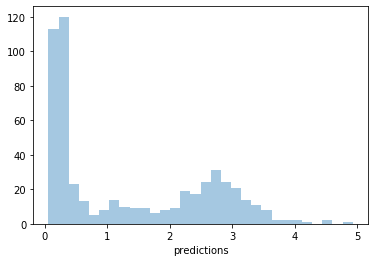

In [138]:
sns.distplot(test_copy['predictions'], kde=False, bins=30)

In [140]:
test_copy.to_parquet('data/gw_predictions/gw2_v1.1_player_predictions.parquet', index=False)